This notebook contains a Convolutional Variational Autoencoder (CVAE) as well as a Convolutional Autoencode (CAE) which are applied on MNIST. The convolutional structure of two networks are the same and both have a 16 dim hidden space.  

Tensorflow==2.3, CUDA==10.1, cuDNN==7.6.5\
was able to run on NVIDIA driver 440.82!

In [15]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras

import matplotlib.pyplot as plt
from scipy.spatial import distance
import time
from IPython import display

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [17]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [18]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Variational Autoencoder (MNIST)

In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [6]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
#   this makes each pixel a binary value of either 0 or 1
#   return np.where(images > .5, 1.0, 0.0).astype('float32')
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [7]:
train_size = 60000
batch_size = 32
test_size = 10000

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [37]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [38]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# ELBO loss for VAEs
# log p(x|z) + log p(z) - log q(z|x) where q is the estimate of true probability p(z)
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [39]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 16
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
# random_vector_for_generation = tf.random.normal(
#     shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [40]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
#   z = model.reparameterize(mean, logvar)
  predictions = model.sample(mean)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [41]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -105.80013275146484, time elapse for current epoch: 10.383004903793335


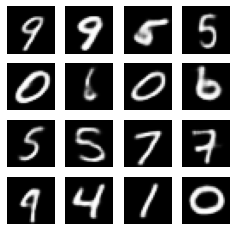

In [42]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [43]:
# inspect the latent space for test images.
m_all, logvar = model.encode(test_images)
m_all = np.array(m_all)

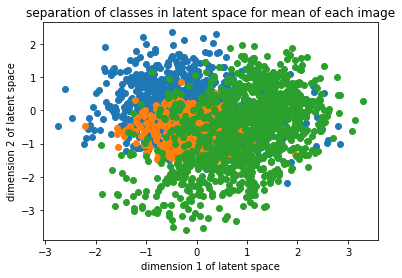

In [44]:
fig = plt.figure()
plt.scatter(m_all[np.where(test_labels==0),0], m_all[np.where(test_labels==0),1])
plt.scatter(m_all[np.where(test_labels==1),0], m_all[np.where(test_labels==1),1])
plt.scatter(m_all[np.where(test_labels==2),0], m_all[np.where(test_labels==2),1])
# plt.scatter(m_all[np.where(test_labels==3),0], m_all[np.where(test_labels==3),1])
plt.title("separation of classes in latent space for mean of each image")
plt.xlabel("dimension 1 of latent space")
plt.ylabel("dimension 2 of latent space")
plt.show()

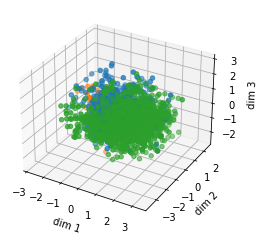

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m_all[np.where(test_labels==0),0], m_all[np.where(test_labels==0),1], m_all[np.where(test_labels==0),2])
ax.scatter(m_all[np.where(test_labels==1),0], m_all[np.where(test_labels==1),1], m_all[np.where(test_labels==1),2])
ax.scatter(m_all[np.where(test_labels==2),0], m_all[np.where(test_labels==2),1], m_all[np.where(test_labels==2),2])
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')

plt.show()

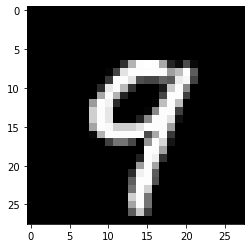

In [46]:
# show how close the real and reconstructed images are, if mean of each test image is decoded
img = test_images[12]
plt.imshow(img.reshape((28,28)), cmap='gray')

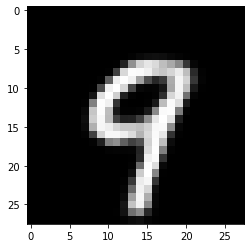

In [47]:
mean, var = model.encode(test_images[12:13])
re_img = model.sample(mean)
plt.imshow(tf.reshape(re_img, (28,28)), cmap='gray')


In [50]:
# For each class compute the intra class distances. i.e. 1/[2*n*(n-1)] \sum dist(x_i, x_j)
for i in range(10):
    num_mems = m_all[np.where(test_labels==i)].shape[0]
    membs = m_all[np.where(test_labels==i)]
    avg_intera_dist = np.sum(distance.cdist(membs, membs))/(2*num_mems*(num_mems-1))
    print("Average intra-cluster distance for label {} = {}". format(i, avg_intera_dist))

Average intra-cluster distance for label 0 = 2.234415143862172
Average intra-cluster distance for label 1 = 1.7822653524471137
Average intra-cluster distance for label 2 = 2.445068222109464
Average intra-cluster distance for label 3 = 2.1462632325753925
Average intra-cluster distance for label 4 = 2.2918812000831243
Average intra-cluster distance for label 5 = 2.358419205237493
Average intra-cluster distance for label 6 = 2.1653149852830538
Average intra-cluster distance for label 7 = 2.09895604744798
Average intra-cluster distance for label 8 = 2.0572206119370056
Average intra-cluster distance for label 9 = 1.978684651342512


In [49]:
#Compute average inter cluster distance of one class with all the other classes
i = 1
sum_dist = 0.0

for j in [x for x in range(10) if x != i]:
    num_mems = m_all[np.where(test_labels==i)].shape[0]
    num_membs_other = m_all[np.where(test_labels==j)].shape[0]
    membs = m_all[np.where(test_labels==i)]
    membs_other = m_all[np.where(test_labels==j)]
    sum_dist = sum_dist + np.sum(distance.cdist(membs, membs_other))/(2*num_mems*num_membs_other)
    
avg_inter_dist = sum_dist / 9
# avg_inter_dist = sum_dist

print("Average intra cluster distance for label {} = {}". format(i, avg_inter_dist))

Average intra cluster distance for label 1 = 2.6997147683237492


# Autoencoder MNIST

In [19]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [20]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
#   this makes each pixel a binary value of either 0 or 1
#   return np.where(images > .5, 1.0, 0.0).astype('float32')
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [21]:
train_size = 60000
batch_size = 32
test_size = 10000

In [22]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [23]:
class CAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def encode(self, x):
    return self.encoder(x)

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [24]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model, x):
  r= model.encode(x)
  x_logit = model.decode(r)
#   err = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  err = tf.square(tf.subtract(x_logit, x))
  return tf.reduce_mean(err)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [25]:
latent_dim =16
epochs = 10
num_examples_to_generate = 16
model_ae = CAE(latent_dim) 
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

In [26]:
def generate_and_save_images(model, epoch, test_sample):
  r = model.encode(test_sample)
  predictions = model.decode(r)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.show()

In [27]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set L2 Loss: 0.00947808101773262, time elapse for current epoch: 9.176660299301147


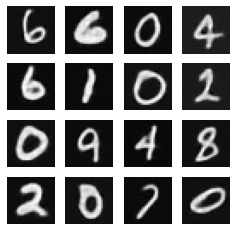

In [28]:
generate_and_save_images(model_ae, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model_ae, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model_ae, test_x))
  l2loss = loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set L2 Loss: {}, time elapse for current epoch: {}'
        .format(epoch, l2loss, end_time - start_time))
  generate_and_save_images(model_ae, epoch, test_sample)

In [29]:
# inspect the latent space for test images.
m_all = model_ae.encode(test_images)
m_all = np.array(m_all)

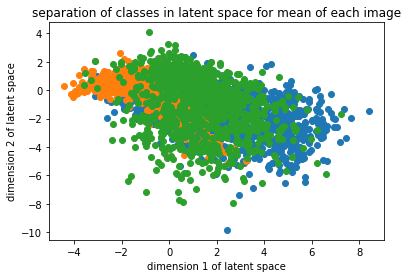

In [30]:
fig = plt.figure()
plt.scatter(m_all[np.where(test_labels==0),0], m_all[np.where(test_labels==0),1])
plt.scatter(m_all[np.where(test_labels==1),0], m_all[np.where(test_labels==1),1])
plt.scatter(m_all[np.where(test_labels==2),0], m_all[np.where(test_labels==2),1])
# plt.scatter(m_all[np.where(test_labels==3),0], m_all[np.where(test_labels==3),1])
# plt.scatter(m_all[np.where(test_labels==4),0], m_all[np.where(test_labels==4),1])
# plt.scatter(m_all[np.where(test_labels==5),0], m_all[np.where(test_labels==5),1])
# plt.scatter(m_all[np.where(test_labels==6),0], m_all[np.where(test_labels==6),1])
# plt.scatter(m_all[np.where(test_labels==7),0], m_all[np.where(test_labels==7),1])
# plt.scatter(m_all[np.where(test_labels==8),0], m_all[np.where(test_labels==8),1])
# plt.scatter(m_all[np.where(test_labels==9),0], m_all[np.where(test_labels==9),1])
plt.title("separation of classes in latent space for mean of each image")
plt.xlabel("dimension 1 of latent space")
plt.ylabel("dimension 2 of latent space")
plt.show()

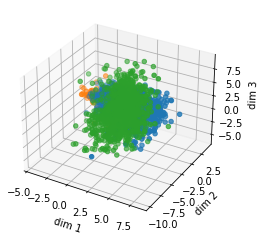

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(m_all[np.where(test_labels==0),0], m_all[np.where(test_labels==0),1], m_all[np.where(test_labels==0),2])
ax.scatter(m_all[np.where(test_labels==1),0], m_all[np.where(test_labels==1),1], m_all[np.where(test_labels==1),2])
ax.scatter(m_all[np.where(test_labels==2),0], m_all[np.where(test_labels==2),1], m_all[np.where(test_labels==2),2])
# ax.scatter(m_all[np.where(test_labels==3),0], m_all[np.where(test_labels==3),1], m_all[np.where(test_labels==3),2])
# ax.scatter(m_all[np.where(test_labels==4),0], m_all[np.where(test_labels==4),1], m_all[np.where(test_labels==4),2])
# ax.scatter(m_all[np.where(test_labels==5),0], m_all[np.where(test_labels==5),1], m_all[np.where(test_labels==5),2])
# ax.scatter(m_all[np.where(test_labels==6),0], m_all[np.where(test_labels==6),1], m_all[np.where(test_labels==6),2])
# ax.scatter(m_all[np.where(test_labels==7),0], m_all[np.where(test_labels==7),1], m_all[np.where(test_labels==7),2])
# ax.scatter(m_all[np.where(test_labels==8),0], m_all[np.where(test_labels==8),1], m_all[np.where(test_labels==8),2])
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')

plt.show()

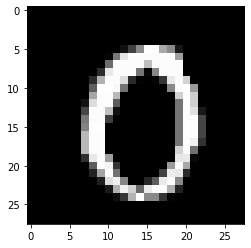

In [32]:
img = test_images[13]
plt.imshow(img.reshape((28,28)), cmap='gray')

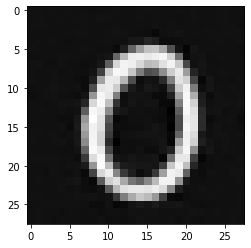

In [33]:
r = model_ae.encode(test_images[13:14])
re_img = model_ae.decode(r)
plt.imshow(tf.reshape(re_img, (28,28)), cmap='gray')


In [34]:
# For each class compute the intra class distances. i.e. 1/[2*n*(n-1)] \sum dist(x_i, x_j)
for i in range(10):
    num_mems = m_all[np.where(test_labels==i)].shape[0]
    membs = m_all[np.where(test_labels==i)]
    avg_intera_dist = np.sum(distance.cdist(membs, membs))/(2*num_mems*(num_mems-1))
    print("Average intra-cluster distance for label {} = {}". format(i, avg_intera_dist))

Average intra-cluster distance for label 0 = 5.034560019915956
Average intra-cluster distance for label 1 = 3.325110120538201
Average intra-cluster distance for label 2 = 5.444370050310356
Average intra-cluster distance for label 3 = 4.7156826715743785
Average intra-cluster distance for label 4 = 4.833704375614016
Average intra-cluster distance for label 5 = 5.2371518504329835
Average intra-cluster distance for label 6 = 4.73854537657015
Average intra-cluster distance for label 7 = 4.404200668076673
Average intra-cluster distance for label 8 = 4.577651990124756
Average intra-cluster distance for label 9 = 4.29501223454275


In [36]:
#Compute average inter cluster distance of one class with all the other classes
i = 1
sum_dist = 0.0

for j in [x for x in range(10) if x != i]:
    num_mems = m_all[np.where(test_labels==i)].shape[0]
    num_membs_other = m_all[np.where(test_labels==j)].shape[0]
    membs = m_all[np.where(test_labels==i)]
    membs_other = m_all[np.where(test_labels==j)]
    sum_dist = sum_dist + np.sum(distance.cdist(membs, membs_other))/(2*num_mems*num_membs_other)
    
avg_inter_dist = sum_dist / 9
# avg_inter_dist = sum_dist

print("Average intra cluster distance for label {} = {}". format(i, avg_inter_dist))

Average intra cluster distance for label 1 = 6.1848853427963615
